# Alzheimer's Disease Classification

We trained a deep learning model such as use InceptionV3 on the training set of MRI images, with the corresponding class labels (i.e. Mild Demented, Moderate Demented, Non Demented, and Very Mild Demented) as the ground truth. The model can then be used to predict the class of MRI images in the testing set. The accuracy of the classification can be evaluated by comparing the predicted class labels with the true class labels of the testing set. The model can be fine-tuned using various hyperparameters, such as learning rate, number of layers, and batch size, to improve its accuracy.

### 1. Libraries

All the necessary libraries that need to be installed to run the code:

- os
- numpy
- matplotlib
- distutils
- sklearn
- tensorflow
- tensorflow_addons
- imblearn

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from distutils.dir_util import copy_tree
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

### 2. Prepare Data

In [ ]:
def prepare_data(base_dir, train_dir, test_dir, work_dir, img_size, zoom_range, brightness_range, horizontal_flip, fill_mode, data_format):
    
    # Check if the work_dir exists, if not, create it
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    # Copy train and test data into the work directory
    copy_tree(train_dir, work_dir)
    copy_tree(test_dir, work_dir)

    # Define image augmentation parameters
    image_augmenter = IDG(
        rescale=1./255,
        brightness_range=brightness_range,
        zoom_range=zoom_range,
        data_format=data_format,
        fill_mode=fill_mode,
        horizontal_flip=horizontal_flip
    )
    
    # Generate augmented training data
    train_data_gen = image_augmenter.flow_from_directory(
        directory=work_dir,
        target_size=img_size,
        batch_size=6500,
        shuffle=False
    )
    
    # Extract data and labels from the augmented training data
    train_data, train_labels = train_data_gen.next()
    
    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    flattened_data = train_data.reshape(-1, np.prod(img_size) * 3)  # Reshape data to 2D array
    flattened_data, train_labels = smote.fit_resample(flattened_data, train_labels)  # Apply SMOTE
    train_data = flattened_data.reshape(-1, *img_size, 3)  # Reshape data back to 3D array

    # Split the data into train, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

    return train_data, val_data, test_data, train_labels, val_labels, test_labels


**TODO**: To use this code, please change the *base_directory* variable to the path where you have saved the Alzheimer's dataset.

In [ ]:
# folder = "YOUR FOLDER"

In [ ]:
# Using Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

# folder = "/content/drive/MyDrive"

In [ ]:
base_directory = folder + "/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"

In [ ]:
root_directory = "./"
test_directory = base_directory + "test/"
train_directory = base_directory + "train/"
work_directory = root_directory + "dataset/"

image_size = (176, 176)

In [ ]:
# Prepare data
train_data, val_data, test_data, train_labels, val_labels, test_labels = prepare_data(base_directory, train_directory, test_directory, work_directory, image_size, [0.99, 1.01], [0.8, 1.2], True, "constant", "channels_last")

Expect output:

Found 6400 images belonging to 4 classes.

### 3. Model Construction

In [ ]:
def construct_model(image_size, activation='relu'):
    # Convolutional block
    def conv_block(filters, act=activation):
        block = Sequential()
        block.add(Conv2D(filters, 3, activation=act, padding='same'))
        block.add(Conv2D(filters, 3, activation=act, padding='same'))
        block.add(BatchNormalization())
        block.add(MaxPool2D())
        return block

    # Dense block
    def dense_block(units, dropout_rate, act=activation):
        block = Sequential()
        block.add(Dense(units, activation=act))
        block.add(BatchNormalization())
        block.add(Dropout(dropout_rate))
        return block
    
    # Model architecture
    model = Sequential([
        Input(shape=(*image_size, 3)),
        Conv2D(16, 3, activation=activation, padding='same'),
        Conv2D(16, 3, activation=activation, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')
        ], name="cnn_model")
    return model

### 4. Model

In [ ]:
model = construct_model(image_size)

In [ ]:
# Defining a custom callback function
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

### 5. Metrics

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]
CALLBACKS = [my_callback]
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)
model.summary()

Expect output:

Model: "cnn_model"

|Layer (type)|Output Shape|Param #|
|---|---|---|
|conv2d_1 (Conv2D)|	(None, 176, 176, 16)|	2320|
|max_pooling2d (MaxPooling2D)|	(None, 88, 88, 16)|	0|
|sequential (Sequential)|	(None, 44, 44, 32)|	14016|
|sequential_1 (Sequential)|	(None, 22, 22, 64)|	55680|
|sequential_2 (Sequential)|	(None, 11, 11, 128)|	221952|
|dropout (Dropout)|	(None, 11, 11, 128)|	0|
|sequential_3 (Sequential)|	(None, 5, 5, 256)|	886272|
|dropout_1 (Dropout)|	(None, 5, 5, 256)|	0|
|flatten (Flatten)|	(None, 6400)|	0|
|sequential_4 (Sequential)|	(None, 512)|	3279360|
|sequential_5 (Sequential)|	(None, 128)|	66176|
|sequential_6 (Sequential)|	(None, 64)|	8512|
|dense_3 (Dense)|	(None, 4)|	260|

Total params: 4,534,996

Trainable params: 4,532,628

Non-trainable params: 2,368

### 6. Train

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=100)

Expect output:

Epoch 1/100

256/256 [==============================] - 22s 54ms/step - loss: 1.8563 - acc: 0.2845 - auc: 0.5456 - f1_score: 0.2828 - val_loss: 5.0652 - val_acc: 0.2402 - val_auc: 0.5055 - val_f1_score: 0.0969

Epoch 2/100

256/256 [==============================] - 13s 50ms/step - loss: 1.0740 - acc: 0.5216 - auc: 0.7932 - f1_score: 0.5074 - val_loss: 1.7626 - val_acc: 0.3462 - val_auc: 0.6271 - val_f1_score: 0.2902

...

...

### 7. Results

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()
for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Expect output:

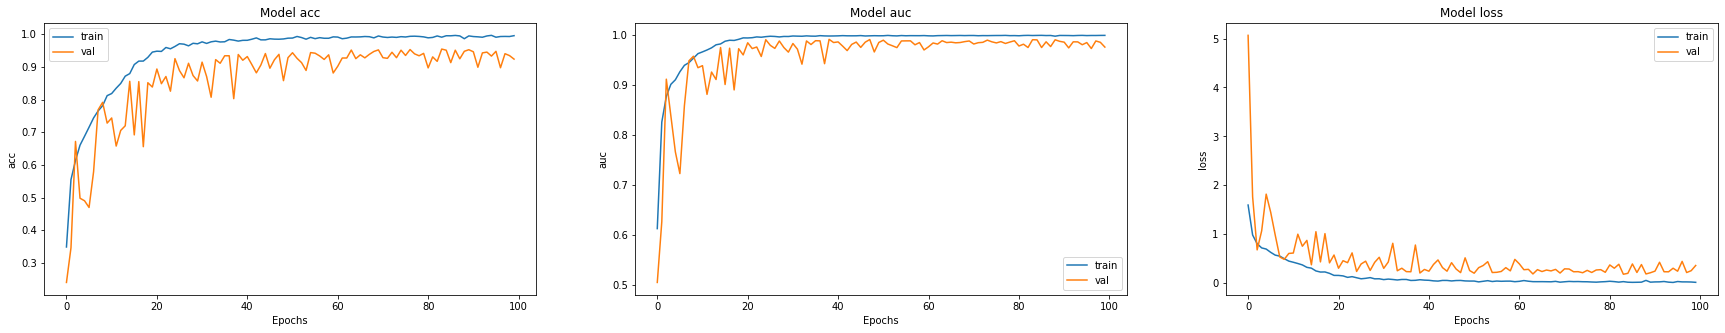

In [ ]:
# Evaluating the model on the data
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Expect output:

80/80 [==============================] - 1s 15ms/step - loss: 0.3572 - acc: 0.9238 - auc: 0.9777 - f1_score: 0.9231

Testing Accuracy: 92.38%

In [ ]:
# Predicting the test data
pred_labels = model.predict(test_data)

def round(arr):
    """To round off according to the argmax of each predicted label array using an alternative method."""
    return np.eye(arr.shape[1])[np.argmax(arr, axis=1)]

pred_labels_rounded = round(pred_labels)
print(classification_report(test_labels, pred_labels_rounded, target_names=CLASSES))

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Expect output:

Balanced Accuracy Score: 93.46 %

Matthew's Correlation Coefficient: 91.61 %

Data source: Kaggle, Alzheimer's Dataset ( 4 class of Images)